# Improving One-vs-Rest Multiclass Classification with Unsupervised Structure (Digits)
This notebook implements the full experiment described in the project: use unsupervised clustering (KMeans, GMM, Agglomerative) to find latent structure and incorporate that into a One-vs-Rest (OVR) logistic-regression multiclass system via several approaches.

**What the notebook contains**
- Baseline OVR logistic regression
- Clustering analysis (KMeans, GMM, Agglomerative) + ARI/NMI
- Approach A: cluster one-hot features (feature augmentation)
- Approach B: cluster-specific classifiers (local experts) with fallback
- Approach C: GMM soft probabilities as features + stacking
- Visualizations (PCA plots, confusion matrices)
- Repeated-seed stability check and a short report template

**Notes about dependencies**
If you're running in a fresh environment (e.g., Google Colab), you may need to install packages. There's an optional cell (commented) below with `pip install` commands — uncomment and run it if needed.


In [6]:
# Optional: uncomment and run if packages are missing (useful in Colab)
# !pip install scikit-learn pandas matplotlib seaborn numpy nbformat
pass


Samples: 1797 | Features: 64 | Classes: 10
Baseline Accuracy: 0.9685 | Macro F1: 0.9685\n
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        54
           1       0.93      0.93      0.93        55
           2       1.00      1.00      1.00        53
           3       0.98      0.98      0.98        55
           4       0.96      0.98      0.97        54
           5       0.98      0.98      0.98        55
           6       1.00      0.98      0.99        54
           7       0.96      1.00      0.98        54
           8       0.89      0.92      0.91        52
           9       0.98      0.93      0.95        54

    accuracy                           0.97       540
   macro avg       0.97      0.97      0.97       540
weighted avg       0.97      0.97      0.97       540



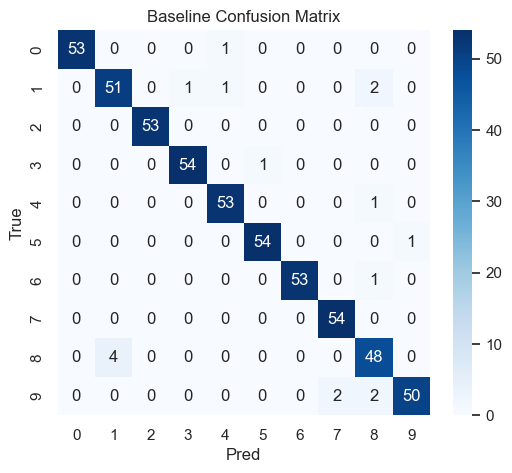

KMeans: ARI=0.5540 NMI=0.6968
GMM:    ARI=0.5915 NMI=0.7154
Agglom: ARI=0.6902 NMI=0.7964


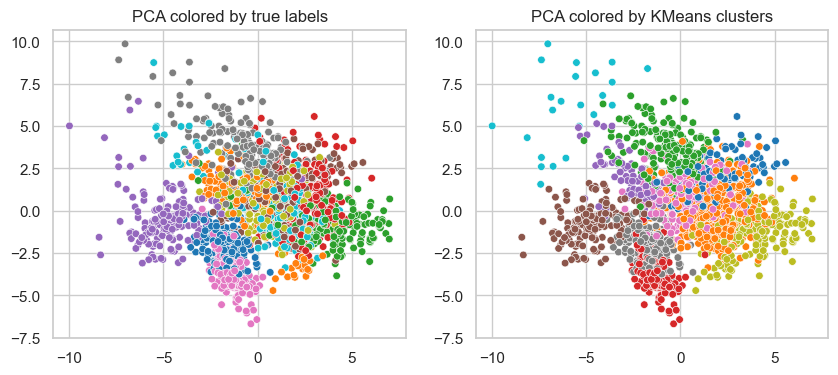

Augmented (one-hot clusters) Accuracy: 0.9574 | Macro F1: 0.9575\n
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        54
           1       0.88      0.93      0.90        55
           2       0.98      1.00      0.99        53
           3       1.00      0.96      0.98        55
           4       0.95      0.98      0.96        54
           5       1.00      0.98      0.99        55
           6       1.00      0.96      0.98        54
           7       0.95      0.98      0.96        54
           8       0.85      0.88      0.87        52
           9       0.98      0.91      0.94        54

    accuracy                           0.96       540
   macro avg       0.96      0.96      0.96       540
weighted avg       0.96      0.96      0.96       540



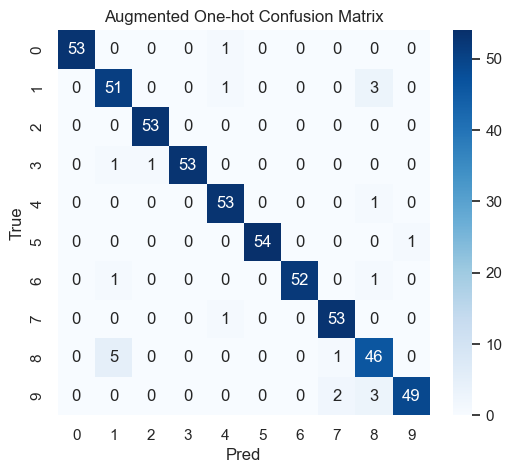

Cluster-specific Accuracy: 0.9556 | Macro F1: 0.9554\n
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        54
           1       0.92      0.98      0.95        55
           2       0.96      0.98      0.97        53
           3       1.00      0.98      0.99        55
           4       0.91      0.94      0.93        54
           5       0.94      0.93      0.94        55
           6       1.00      0.96      0.98        54
           7       0.91      0.96      0.94        54
           8       0.96      0.87      0.91        52
           9       0.96      0.96      0.96        54

    accuracy                           0.96       540
   macro avg       0.96      0.96      0.96       540
weighted avg       0.96      0.96      0.96       540

Cluster sizes (train): {0: 89, 1: 299, 2: 132, 3: 128, 4: 68, 5: 114, 6: 168, 7: 124, 8: 120, 9: 15}


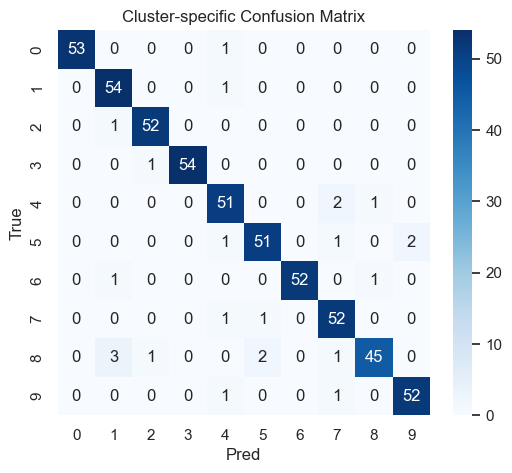

GMM-prob features Accuracy: 0.9537 | Macro F1: 0.9538\n
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        54
           1       0.89      0.93      0.91        55
           2       0.96      1.00      0.98        53
           3       0.98      0.96      0.97        55
           4       0.96      0.98      0.97        54
           5       1.00      0.98      0.99        55
           6       1.00      0.96      0.98        54
           7       0.95      1.00      0.97        54
           8       0.82      0.90      0.86        52
           9       0.98      0.89      0.93        54

    accuracy                           0.95       540
   macro avg       0.96      0.95      0.95       540
weighted avg       0.96      0.95      0.95       540



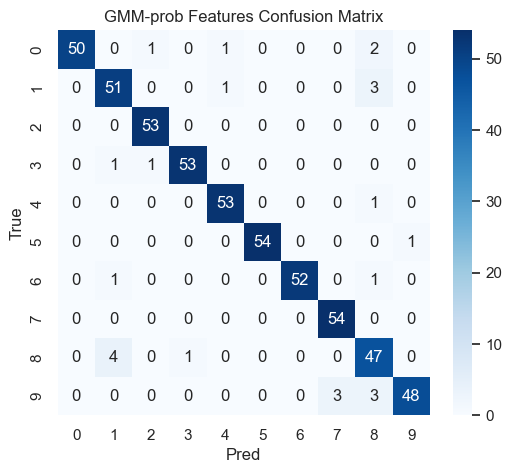

                  accuracy  macro_f1
method                              
baseline          0.968519  0.968455
augmented_onehot  0.957407  0.957491
cluster_specific  0.955556  0.955399
gmm_probs         0.953704  0.953804
\nSaved summary table to experiment_summary_digits.csv


In [7]:
# Imports and helper functions
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from collections import defaultdict

RANDOM_STATE = 42
sns.set(style='whitegrid')

# Pretty confusion matrix
def plot_confusion(cm, labels, title='Confusion matrix'):
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.ylabel('True')
    plt.xlabel('Pred')
    plt.title(title)
    plt.show()

def evaluate(y_true, y_pred, labels=None):
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    report = classification_report(y_true, y_pred, target_names=[str(l) for l in (labels if labels is not None else sorted(set(y_true)))])
    cm = confusion_matrix(y_true, y_pred)
    return {'accuracy': acc, 'macro_f1': macro_f1, 'report': report, 'cm': cm}

# Load digits and preprocessing
X, y = datasets.load_digits(return_X_y=True)
labels = datasets.load_digits().target_names
print('Samples:', X.shape[0], '| Features:', X.shape[1], '| Classes:', len(np.unique(y)))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y)

# Baseline OVR logistic regression
baseline_clf = make_pipeline(StandardScaler(), OneVsRestClassifier(LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)))
baseline_clf.fit(X_train, y_train)
y_pred_base = baseline_clf.predict(X_test)
base_eval = evaluate(y_test, y_pred_base, labels)
print('Baseline Accuracy: {:.4f} | Macro F1: {:.4f}\\n'.format(base_eval['accuracy'], base_eval['macro_f1']))
print(base_eval['report'])
plot_confusion(base_eval['cm'], labels, title='Baseline Confusion Matrix')

# Clustering: KMeans, GMM, Agglomerative
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE)
kmeans.fit(X_train)
train_clusters_k = kmeans.predict(X_train)
test_clusters_k = kmeans.predict(X_test)
ari_k = adjusted_rand_score(y_train, train_clusters_k)
nmi_k = normalized_mutual_info_score(y_train, train_clusters_k)
print('KMeans: ARI={:.4f} NMI={:.4f}'.format(ari_k, nmi_k))

gmm = GaussianMixture(n_components=n_clusters, random_state=RANDOM_STATE)
gmm.fit(X_train)
train_clusters_g = gmm.predict(X_train)
test_clusters_g = gmm.predict(X_test)
ari_g = adjusted_rand_score(y_train, train_clusters_g)
nmi_g = normalized_mutual_info_score(y_train, train_clusters_g)
print('GMM:    ARI={:.4f} NMI={:.4f}'.format(ari_g, nmi_g))

agg = AgglomerativeClustering(n_clusters=n_clusters)
train_clusters_a = agg.fit_predict(X_train)
centroids = np.vstack([X_train[train_clusters_a==i].mean(axis=0) for i in range(n_clusters)])
dists = np.linalg.norm(X_test[:, None, :] - centroids[None, :, :], axis=2)
test_clusters_a = dists.argmin(axis=1)
ari_a = adjusted_rand_score(y_train, train_clusters_a)
nmi_a = normalized_mutual_info_score(y_train, train_clusters_a)
print('Agglom: ARI={:.4f} NMI={:.4f}'.format(ari_a, nmi_a))

# PCA visualizations
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X2 = pca.fit_transform(np.vstack([X_train, X_test]))
labels_full = np.hstack([y_train, y_test])
clusters_k_full = np.hstack([train_clusters_k, test_clusters_k])

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.scatterplot(x=X2[:,0], y=X2[:,1], hue=labels_full, palette='tab10', legend=None, s=30)
plt.title('PCA colored by true labels')
plt.subplot(1,2,2)
sns.scatterplot(x=X2[:,0], y=X2[:,1], hue=clusters_k_full, palette='tab10', legend=None, s=30)
plt.title('PCA colored by KMeans clusters')
plt.show()

# Approach A: Augment with cluster one-hot
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
train_clusters_k_ohe = enc.fit_transform(train_clusters_k.reshape(-1,1))
test_clusters_k_ohe = enc.transform(test_clusters_k.reshape(-1,1))
X_train_aug = np.hstack([X_train, train_clusters_k_ohe])
X_test_aug = np.hstack([X_test, test_clusters_k_ohe])

clf_aug = make_pipeline(StandardScaler(), OneVsRestClassifier(LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)))
clf_aug.fit(X_train_aug, y_train)
y_pred_aug = clf_aug.predict(X_test_aug)
aug_eval = evaluate(y_test, y_pred_aug, labels)
print('Augmented (one-hot clusters) Accuracy: {:.4f} | Macro F1: {:.4f}\\n'.format(aug_eval['accuracy'], aug_eval['macro_f1']))
print(aug_eval['report'])
plot_confusion(aug_eval['cm'], labels, title='Augmented One-hot Confusion Matrix')

# Approach B: Cluster-specific classifiers (local experts)
cluster_clfs = {}
cluster_sizes = {}
for k in range(n_clusters):
    idx = np.where(train_clusters_k == k)[0]
    cluster_sizes[k] = len(idx)
    if len(idx) < 12:
        cluster_clfs[k] = None
        continue
    clf = OneVsRestClassifier(LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
    clf.fit(X_train[idx], y_train[idx])
    cluster_clfs[k] = clf

y_pred_spec = np.zeros_like(y_test)
for i, k in enumerate(test_clusters_k):
    clf = cluster_clfs.get(k)
    if clf is None:
        y_pred_spec[i] = baseline_clf.predict(X_test[i].reshape(1,-1))[0]
    else:
        y_pred_spec[i] = clf.predict(X_test[i].reshape(1,-1))[0]

spec_eval = evaluate(y_test, y_pred_spec, labels)
print('Cluster-specific Accuracy: {:.4f} | Macro F1: {:.4f}\\n'.format(spec_eval['accuracy'], spec_eval['macro_f1']))
print(spec_eval['report'])
print('Cluster sizes (train):', cluster_sizes)
plot_confusion(spec_eval['cm'], labels, title='Cluster-specific Confusion Matrix')

# Approach C: GMM-prob features
train_probs = gmm.predict_proba(X_train)
test_probs = gmm.predict_proba(X_test)
X_train_gmm = np.hstack([X_train, train_probs])
X_test_gmm = np.hstack([X_test, test_probs])

clf_gmm = make_pipeline(StandardScaler(), OneVsRestClassifier(LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)))
clf_gmm.fit(X_train_gmm, y_train)
y_pred_gmm = clf_gmm.predict(X_test_gmm)
gmm_eval = evaluate(y_test, y_pred_gmm, labels)
print('GMM-prob features Accuracy: {:.4f} | Macro F1: {:.4f}\\n'.format(gmm_eval['accuracy'], gmm_eval['macro_f1']))
print(gmm_eval['report'])
plot_confusion(gmm_eval['cm'], labels, title='GMM-prob Features Confusion Matrix')

# Summary table
summary_df = pd.DataFrame([
    ['baseline', base_eval['accuracy'], base_eval['macro_f1']],
    ['augmented_onehot', aug_eval['accuracy'], aug_eval['macro_f1']],
    ['cluster_specific', spec_eval['accuracy'], spec_eval['macro_f1']],
    ['gmm_probs', gmm_eval['accuracy'], gmm_eval['macro_f1']]
], columns=['method','accuracy','macro_f1']).set_index('method')

print(summary_df)
summary_df.to_csv('experiment_summary_digits.csv')
print('\\nSaved summary table to experiment_summary_digits.csv')

## Report template (auto-filled in the notebook)
Use the printed summary above to copy into your project report. The notebook also saves `experiment_summary_digits.csv` with the numeric results.